In [1]:
import sys 
sys.path.append("..")
from src.dataset import Dataset
import pandas as pd
import os

In [2]:
# dataset_generator = Dataset("compas", ignore_features=["id", "age_cat", "priors_count.1", "violent_recid"])
dataset_generator = Dataset("adult")
target = dataset_generator.target
SAMPLING_METHOD = "class_protected"
GENERATION_METHOD = "cart"



Dataset adult_fnlwgt_educational-num has ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'native-country'] categorical and ['age', 'capital-gain', 'capital-loss', 'hours-per-week'] numerical columns.


In [3]:
protected_attributes = ["sex"]
split_dfs, additional_sizes = dataset_generator.split_population(dataset_generator.original_dataframe, protected_attributes)


/home/panagiotou/Desktop/FairAugment/util/../src/dataset.py:601: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for attr_values, indices in dataframe.groupby(protected_attributes).groups.items():


In [4]:
split_df_keys, split_df_vals = zip(*split_dfs.items())
from definitions import get_synthetic_splits


final_augmented_dataset_plots = []
sampling_methods = ['class', 'class_protected', 'protected', 'same_class']
sampling_methods_names = ['class', 'class-protected', 'protected', 'class (same)']

for sampling_method in sampling_methods:
    augmented_dfs, augmented_dfs_plot = get_synthetic_splits(dataset_generator, split_dfs, generative_method=GENERATION_METHOD, generative_seed=0, return_plot=True, sampling_method=sampling_method)
    final_augmented_dataset = pd.concat(augmented_dfs)
    final_augmented_dataset_plot = pd.concat(augmented_dfs_plot)
    final_augmented_dataset_plot['target_method'] = final_augmented_dataset_plot[target].astype(str) + ' (' + final_augmented_dataset_plot['method'].astype(str) + ')'
    final_augmented_dataset_plots.append(final_augmented_dataset_plot)

/home/panagiotou/anaconda3/envs/samplestructures/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/panagiotou/anaconda3/envs/samplestructures/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/panagiotou/anaconda3/envs/samplestructures/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/ho

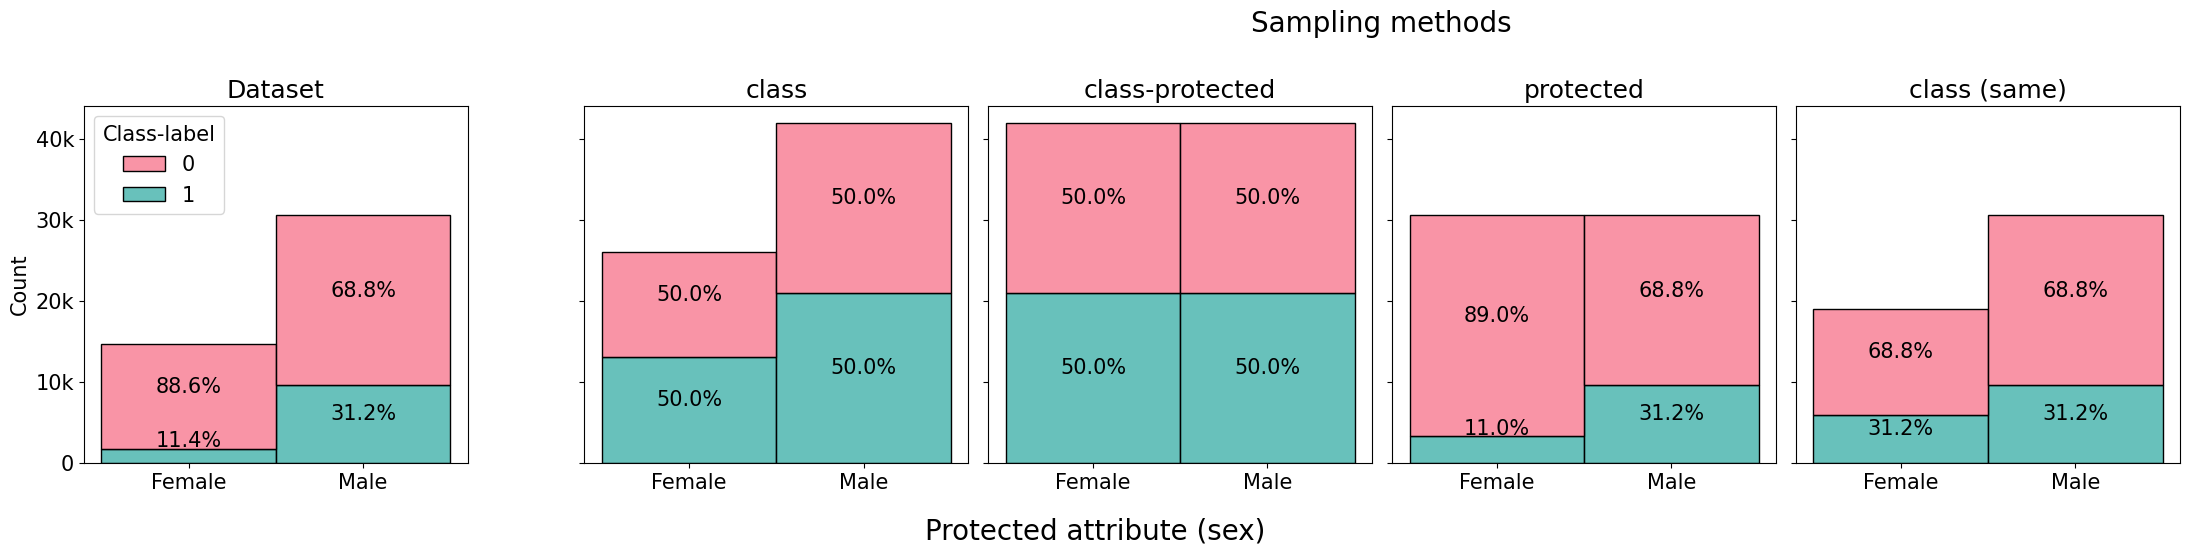

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Function to format y-axis labels
def format_ytick(x, pos):
    if x >= 1000:
        return '{:1.0f}k'.format(x*1e-3)
    else:
        return '{:1.0f}'.format(x)

# Apply the formatter to the y-axis
# Assuming you have two different DataFrames: df1 and df2
# Replace df1 and df2 with your actual DataFrame names


# Set up the plot with two subplots in two columns
fig, axes = plt.subplots(nrows=1, ncols=2 + len(sampling_methods), figsize=(22, 5.3), sharey=True, sharex=True, gridspec_kw={'width_ratios': [1, 0.2] + [1]*len(sampling_methods)})

# Define the palette using Seaborn's color palette generator
palette = sns.color_palette("husl", 2)  # Using 'husl' palette with 2 colors

gender_order = ['Female', 'Male']  # Adjust as per your actual category order

# Plot for df1
sns.histplot(data=dataset_generator.original_dataframe, x='sex', hue=target, palette=palette, multiple="stack", ax=axes[0], discrete = True)
axes[0].set_title('Dataset', fontsize=18)
axes[0].set_ylabel('Count', fontsize=15)

axes[0].set_xlabel('')


sns.move_legend(axes[0], "upper left", fontsize=15, title_fontsize=15)




for i, final_data in enumerate(final_augmented_dataset_plots):

    sns.histplot(data=final_data, x='sex', hue=target, palette=palette, multiple="stack", ax=axes[i+2], discrete = True, legend=False)
    axes[i+2].set_title('{}'.format(sampling_methods_names[i]), fontsize=18)
    axes[i+2].set_xlabel('')

# Adjust layout

axes[1].axis('off') 

for ax in axes:
    for bar in ax.patches:
        # Find the total height of bars for the current x-coordinate
        total_height = sum(p.get_height() for p in ax.patches if p.get_x() == bar.get_x())
        # Calculate the percentage
        percentage = (bar.get_height() / total_height) * 100
        # Annotate the bar with the percentage

        if bar.get_height() < 5000:
            ax.annotate(f'{percentage:.1f}%', 
                        xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2 + 0.4*bar.get_height()),
                        xytext=(0, 0),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=15)
        else:
            ax.annotate(f'{percentage:.1f}%', 
                xy=(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2),
                xytext=(0, 0),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=15)

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_ytick))

fig.supxlabel("Protected attribute (sex)", fontsize=20)

fig.suptitle("Sampling methods", fontsize=20, y=1.02, x=0.63)  # Set super title

for ax in axes:
    ax.tick_params(axis='x', labelsize=15)  # Set font size for x-axis
    ax.tick_params(axis='y', labelsize=15)  # Set font size for y-axis


plt.tight_layout()

plt.savefig("../results/sampling_methods.jpg", dpi=300, bbox_inches="tight", pad_inches=0)

plt.show()
